В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, confusion_matrix

raw_df = pd.read_csv('train.csv', index_col=0)
raw_df= raw_df.drop(columns=['Surname','id','CustomerId'], errors='ignore')

target = raw_df['Exited']
features = raw_df.drop(columns=['Exited'])
features_train, features_val, target_train,target_val  = train_test_split(features, target, test_size=0.2, random_state=42,stratify=target )

In [58]:
input_cols = list(features)
target_col = 'Exited'

train_inputs = features_train[input_cols].copy()
train_targets = target_train.copy()

val_inputs = features_val[input_cols].copy()
val_targets = target_val.copy()

numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [59]:
# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler',MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot',  OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat',categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])


In [60]:
# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [61]:
# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds



Area under ROC score on Training dataset: 0.88


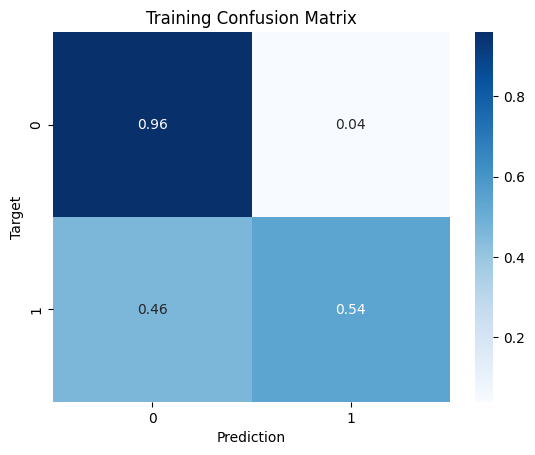

Area under ROC score on Validation dataset: 0.88


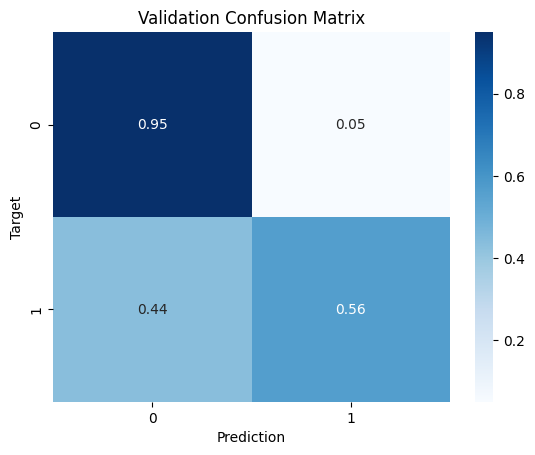

In [62]:
# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

In [63]:
joblib.dump(model_pipeline, 'log_reg.joblib')
model_pipeline_loaded = joblib.load('log_reg.joblib')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [64]:
from sklearn.preprocessing import PolynomialFeatures
numeric_transformer_polynomial = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])
preprocessor_polynomial = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_polynomial, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
model_pipeline_polynomial = Pipeline(steps=[
    ('preprocessor', preprocessor_polynomial),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0))
])


In [65]:
model_pipeline_polynomial.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Area under ROC score on Training Polynomial dataset: 0.92


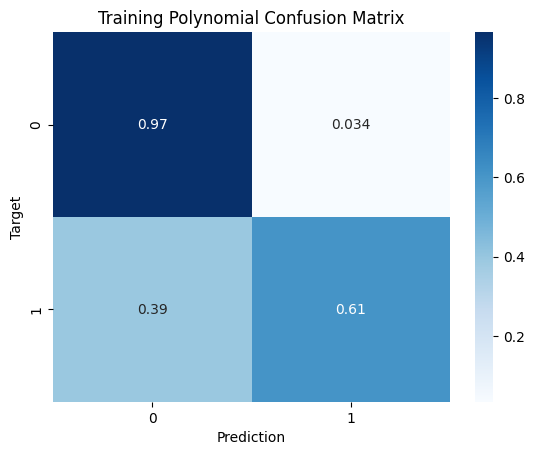

Area under ROC score on Validation Polynomial dataset: 0.92


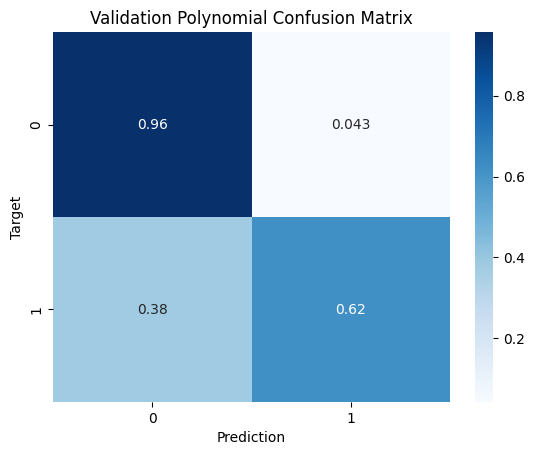

In [66]:
rain_preds_polynomial = predict_and_plot(model_pipeline_polynomial, train_inputs, train_targets, 'Training Polynomial')
val_preds_polynomial = predict_and_plot(model_pipeline_polynomial, val_inputs, val_targets, 'Validation Polynomial')

 Модель добра так як показник ROC становить 92% у порівнянні з попередніми 88%.

 Overfit чи underfit не спостерігається адже показник ROC однаковий як на тестових так і на валідаційних даних

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [67]:
numeric_transformer_polynomial_4 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=4, include_bias=False))
])
preprocessor_polynomial_4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_polynomial_4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
model_pipeline_polynomial_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_polynomial_4),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0))
])


In [68]:
model_pipeline_polynomial_4.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=4,
                                                                                      include_bias=False))]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Area under ROC score on Training Polynomial dataset: 0.93


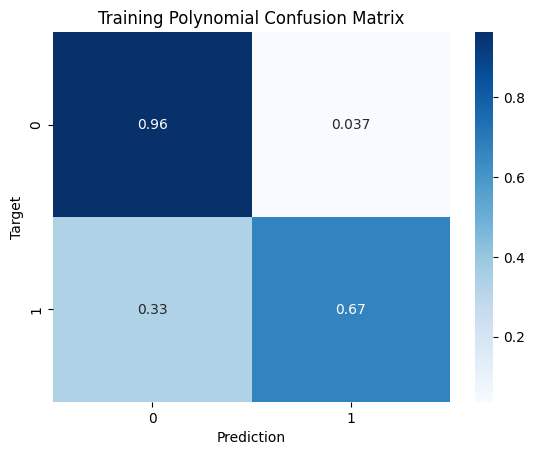

Area under ROC score on Validation Polynomial dataset: 0.93


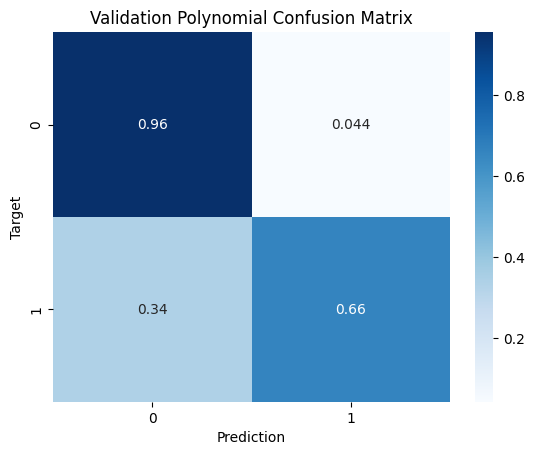

In [69]:
rain_preds_polynomial_4 = predict_and_plot(model_pipeline_polynomial_4, train_inputs, train_targets, 'Training Polynomial')
val_preds_polynomial_4 = predict_and_plot(model_pipeline_polynomial_4, val_inputs, val_targets, 'Validation Polynomial')

Якість моделі покращилась 93% у порівнянні з першими 88%

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [70]:
regression_data_df = pd.read_csv('regression_data.csv', index_col=0)

target = regression_data_df['target']
features = regression_data_df.drop(columns=['target'])
features_train, features_test, target_train,target_test  = train_test_split(features, target, test_size=0.2, random_state=42)

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [72]:
def train_lin_vs_poly_reg_and_plot(features_train, features_test,target_train, target_test, degree):
  # Звичайна лінійна регресія
  lin_reg = LinearRegression()
  lin_reg.fit(features_train, target_train)
  y_pred_train_lin = lin_reg.predict(features_train)
  y_pred_val_lin = lin_reg.predict(features_test)

  # Поліноміальна регресія
  poly_features = PolynomialFeatures(degree=degree)
  X_train_poly = poly_features.fit_transform(features_train)
  X_val_poly = poly_features.transform(features_test)

  print(f'В оригіналній матриці Х {features.shape[1]} ознак.')
  print(f'В матриці Х з поліноміальними ознаками {X_train_poly.shape[1]} ознак.\n')

  poly_reg = LinearRegression()
  poly_reg.fit(X_train_poly, target_train)
  y_pred_train_poly = poly_reg.predict(X_train_poly)
  y_pred_val_poly = poly_reg.predict(X_val_poly)

  # Оцінка моделей

  rmse_lin_train = root_mean_squared_error(target_train, y_pred_train_lin)
  rmse_poly_train = root_mean_squared_error(target_train, y_pred_train_poly)

  rmse_lin_val = root_mean_squared_error(target_test, y_pred_val_lin)
  rmse_poly_val =root_mean_squared_error(target_test, y_pred_val_poly)


  print(f"Train RMSE for Linear Regression: {np.sqrt(rmse_lin_train):.3f}")
  print(f"Test RMSE for Linear Regression: {np.sqrt(rmse_lin_val):.3f}\n")

  print(f"Train RMSE for Polynomial Regression (degree {degree}): {rmse_poly_train:.3f}")
  print(f"Test RMSE for Polynomial Regression (degree {degree}): {rmse_poly_val:.3f}")

In [73]:
degree = 5
train_lin_vs_poly_reg_and_plot(features_train, features_test,target_train, target_test, degree)

В оригіналній матриці Х 4 ознак.
В матриці Х з поліноміальними ознаками 126 ознак.

Train RMSE for Linear Regression: 1.038
Test RMSE for Linear Regression: 0.922

Train RMSE for Polynomial Regression (degree 5): 0.000
Test RMSE for Polynomial Regression (degree 5): 43.929


Модель з  поліноміальними ознаками до степені 5 включно є перенавченою, що видно з втрат тренувальної версії = 0,  у тестовій вже є помилки значні (43,9), тобто модель дуже сильно навчилась на тренувальних даних, а на тестових вже ламається і видає інші результати.

У той час модель лінійної регресії но=а тренувальних та тестових даних не сильно відрізняється.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [79]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    Ridge(),
    Lasso(),
    ElasticNet(),
   ]

In [78]:
def evaluate_model(model, features_train, y_train,features_test, target_test):
    y_train_pred = model.predict(features_train)
    y_val_pred = model.predict(features_test)

    train_metrics = root_mean_squared_error(target_train, y_train_pred)
    val_metrics = root_mean_squared_error(target_test, y_val_pred)

    return dict(train=train_metrics, val=val_metrics)

In [76]:
poly_features = PolynomialFeatures(degree=20)
X_train_poly = poly_features.fit_transform(features_train)
X_test_poly = poly_features.transform(features_test)

In [81]:
import warnings

warnings.filterwarnings("ignore")

for model in models:
    model.fit(X_train_poly, target_train)
    eval_results  = evaluate_model(model, X_train_poly, target_train, X_test_poly,target_test)
    print(f'{str(model)}: {eval_results}\n')

Ridge(): {'train': 28.4330400634758, 'val': 8234.44241254583}

Lasso(): {'train': 2.2404452525693754, 'val': 29.579588876585778}

ElasticNet(): {'train': 11.156551710564438, 'val': 330.83109572323167}



Найкраща модель у даному випадку це модель Lasso  оскільки по ній найменша помилка.

Якщо порівнювати з результатами розрахунків по лінійній регресії то там значення краще помилка складає 0,922.